Casting the dataset:   0%|          | 0/2264 [00:00<?, ? examples/s]

Total samples loaded: 2264
                                            sentence  label label_name
0  According to Gran , the company has no plans t...      1    Neutral
1  For the last quarter of 2010 , Componenta 's n...      2   Positive
2  In the third quarter of 2010 , net sales incre...      2   Positive
3  Operating profit rose to EUR 13.1 mn from EUR ...      2   Positive
4  Operating profit totalled EUR 21.1 mn , up fro...      2   Positive


/tmp/ipython-input-2786912426.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])


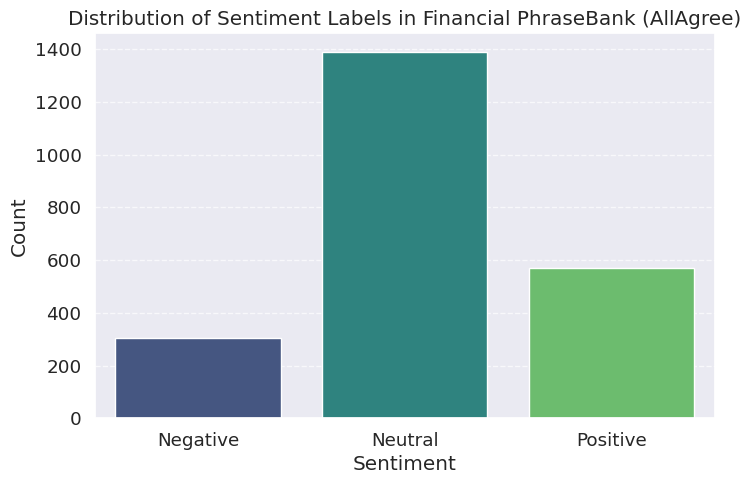


Label Counts:
label_name
Neutral     1391
Positive     570
Negative     303
Name: count, dtype: int64


In [ ]:
# =============================================================================
# UNIFIED IMPORTS - All required libraries
# =============================================================================
import torch
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset as TorchDataset, DataLoader
from torch import nn, optim
import torch.optim as optim
from transformers import BertTokenizer
from tqdm import tqdm

# =============================================================================
# 1. Loading Function (Provided in the prompt)
# =============================================================================

# Reproducibility
SEED = 42
torch.manual_seed(SEED)

def load_financial_phrasebank_manual(split_name="sentences_allagree"):
    """
    Manually loads the Financial Phrasebank dataset using the logic
    extracted from the original financial_phrasebank.py script.
    """
    # 1. CONSTANTS FROM THE SCRIPT
    _URL = "https://huggingface.co/datasets/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip"

    # 2. DETERMINE FILE PATH BASED ON SPLIT
    if split_name == "sentences_allagree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"
    elif split_name == "sentences_75agree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_75Agree.txt"
    elif split_name == "sentences_66agree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_66Agree.txt"
    elif split_name == "sentences_50agree":
        target_filename = "FinancialPhraseBank-v1.0/Sentences_50Agree.txt"
    else:
        raise ValueError(f"Unknown split: {split_name}")

    print(f"Downloading and extracting {_URL}...")

    # 3. DOWNLOAD ZIP (Replicates dl_manager.download_and_extract)
    response = requests.get(_URL)
    response.raise_for_status()

    # 4. PARSE DATA (Replicates _generate_examples)
    data_list = []

    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # The script uses 'iso-8859-1' encoding
        with z.open(target_filename) as f:
            content = f.read().decode("iso-8859-1")

            for line in content.strip().split('\n'):
                # LOGIC FROM SCRIPT: sentence, label = line.rsplit("@", 1)
                try:
                    sentence, label = line.rsplit("@", 1)
                    # Appending to list
                    data_list.append({
                        "sentence": sentence.strip(),
                        "label": label.strip()
                    })
                except ValueError:
                    continue # Skip malformed lines

    # 5. CREATE DATASET OBJECT
    # Define ClassLabel features as per the script's _info method
    label_feature = ClassLabel(names=["negative", "neutral", "positive"])

    # Create basic dataset
    dataset = Dataset.from_list(data_list)

    # Cast label column to ClassLabel (converts strings "negative" -> 0, etc.)
    dataset = dataset.cast_column("label", label_feature)

    return DatasetDict({"train": dataset})

# ---------------------------------------------------------
# Execution & Conversion to DataFrame
# ---------------------------------------------------------

# Load the data (using 'sentences_allagree' as the standard benchmark)
raw_ds = load_financial_phrasebank_manual("sentences_allagree")

# Convert Hugging Face Dataset to Pandas DataFrame
df = raw_ds['train'].to_pandas()

# Map integer labels back to string for visualization clarity if needed,
# but we keep integers for training.
# Mapping based on ClassLabel: 0 -> negative, 1 -> neutral, 2 -> positive
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
df['label_name'] = df['label'].map(label_map)

print(f"Total samples loaded: {len(df)}")
print(df.head())

# ---------------------------------------------------------
# Visualization (Distribution of Labels)
# ---------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.countplot(x='label_name', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])
plt.title('Distribution of Sentiment Labels in Financial PhraseBank (AllAgree)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print exact counts
print("\nLabel Counts:")
print(df['label_name'].value_counts())

In [ ]:
# ---------------------------------------------------------
# TEXT PREPROCESSING AND DATA SPLITTING
# ---------------------------------------------------------
# 0. Download NLTK Stopwords (only needs to run once)
# ---------------------------------------------------------
# این بلوک کد تلاش می‌کند لیست کلمات توقف را لود کند
# اگر دانلود نشده باشد، آن را به صورت خودکار دانلود می‌کند
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

print(f"Loaded {len(stop_words)} English stop words.")

# ---------------------------------------------------------
# 1. Preprocessing Function (Updated)
# ---------------------------------------------------------
def clean_text(text):
    """
    Text cleaning with stop word removal.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters but keep numbers and essential punctuation
    text = re.sub(r'[^a-zA-Z0-9\s%\$\.,]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # --- NEW STEP: Remove Stop Words ---
    # 1. Split text into words
    words = text.split()
    # 2. Keep words that are NOT in the stop_words set
    filtered_words = [word for word in words if word not in stop_words]
    # 3. Join the words back into a sentence
    text = ' '.join(filtered_words)

    return text

# Apply cleaning
df['cleaned_sentence'] = df['sentence'].apply(clean_text)

print("\n--- Example of Cleaning ---")
print("Sample before cleaning:", df['sentence'].iloc[0])
print("Sample after cleaning: ", df['cleaned_sentence'].iloc[0])
print("---------------------------\n")


# ---------------------------------------------------------
# 2. Train / Validation Split (80-20)
# ---------------------------------------------------------
# This part remains the same
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df['label']
)

print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")

# Verify distribution in splits
print("\nTrain Label Distribution:\n", train_df['label_name'].value_counts(normalize=True))
print("\nValidation Label Distribution:\n", val_df['label_name'].value_counts(normalize=True))

Loaded 198 English stop words.

--- Example of Cleaning ---
Sample before cleaning: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sample after cleaning:  according gran , company plans move production russia , although company growing .
---------------------------

Training set size: 1811 (80.0%)
Validation set size: 453 (20.0%)

Train Label Distribution:
 label_name
Neutral     0.614578
Positive    0.251795
Negative    0.133628
Name: proportion, dtype: float64

Validation Label Distribution:
 label_name
Neutral     0.613687
Positive    0.251656
Negative    0.134658
Name: proportion, dtype: float64


In [ ]:
# ==============================================================================
# DATA BALANCING AND DATALOADER SETUP
# ==============================================================================
# مرحله 1: Upsampling برای بالانس کردن داده‌ها

# جدا کردن دیتا فریم بر اساس کلاس‌ها
df_neutral = df[df['label_name'] == 'Neutral']
df_positive = df[df['label_name'] == 'Positive']
df_negative = df[df['label_name'] == 'Negative']

print("--- Original DataFrame Counts ---")
print(df['label_name'].value_counts())
print("---------------------------------\n")

# Upsample کلاس‌های کم‌تعداد
n_samples = len(df_neutral) # تعداد نمونه کلاس اکثریت
df_positive_upsampled = resample(df_positive, replace=True, n_samples=n_samples, random_state=SEED)
df_negative_upsampled = resample(df_negative, replace=True, n_samples=n_samples, random_state=SEED)

# ترکیب مجدد دیتافریم‌ها
df_upsampled = pd.concat([df_neutral, df_positive_upsampled, df_negative_upsampled])

# به هم ریختن ترتیب داده‌ها (Shuffle)
df_upsampled = df_upsampled.sample(frac=1, random_state=SEED).reset_index(drop=True)

print("--- New DataFrame Counts After Upsampling ---")
print(df_upsampled['label_name'].value_counts())
print("---------------------------------------------\n")

# ==============================================================================
# مرحله 2: تقسیم داده‌های بالانس شده به Train و Validation
# ==============================================================================
train_df, val_df = train_test_split(
    df_upsampled,
    test_size=0.2,
    random_state=SEED,
    stratify=df_upsampled['label'] # توزیع برابر کلاس‌ها در train و val
)

print(f"New Training set size: {len(train_df)}")
print(f"New Validation set size: {len(val_df)}\n")


# ==============================================================================
# مرحله 3: ساخت Dataset و DataLoader (کد شما، بدون تغییر)
# ==============================================================================
# این بخش دقیقاً همان کد شماست و به درستی از train_df و val_df جدید استفاده می‌کند.

# 3.1. Custom Dataset Class
class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=128):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'sentence_text': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 3.2. Tokenizer & Dataloader Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 64
BATCH_SIZE = 32

train_dataset = FinancialDataset(
    sentences=train_df['cleaned_sentence'].tolist(),
    labels=train_df['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
val_dataset = FinancialDataset(
    sentences=val_df['cleaned_sentence'].tolist(),
    labels=val_df['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# 3.3. Verify Output
try:
    sample_batch = next(iter(train_loader))
    print("\n--- DataLoader Batch Verification ---")
    print("Input IDs shape:", sample_batch['input_ids'].shape)
    print("Attention Mask shape:", sample_batch['attention_mask'].shape)
    print("Labels shape:", sample_batch['label'].shape)
    print("Sample Sentence:", sample_batch['sentence_text'][0])
    print("Verification Successful!")
except Exception as e:
    print(f"An error occurred during verification: {e}")


--- Original DataFrame Counts ---
label_name
Neutral     1391
Positive     570
Negative     303
Name: count, dtype: int64
---------------------------------

--- New DataFrame Counts After Upsampling ---
label_name
Neutral     1391
Positive    1391
Negative    1391
Name: count, dtype: int64
---------------------------------------------

New Training set size: 3338
New Validation set size: 835


--- DataLoader Batch Verification ---
Input IDs shape: torch.Size([32, 64])
Attention Mask shape: torch.Size([32, 64])
Labels shape: torch.Size([32])
Sample Sentence: connectivity services include outsourced scan capture transfers paper invoices electronic format basware business transactions service enables customer receive send invoices electronic format .
Verification Successful!


In [ ]:
# =============================================================================
# TRANSFORMER MODEL ARCHITECTURE
# =============================================================================
# 1. SelfAttention با قابلیت بازگشت وزن‌ها
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be div by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # *** تغییر مهم: ذخیره وزن‌های توجه ***
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhqk,nkhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention  # برگرداندن attention

# 2. TransformerBlock با قابلیت انتقال وزن‌ها
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        # دریافت attention از لایه self-attention
        attention_output, attention_weights = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention_output + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, attention_weights # انتقال وزن‌ها به بیرون

# 3. FinancialTransformer نهایی
class FinancialTransformer(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length, num_classes):
        super(FinancialTransformer, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(embed_size, heads, dropout=dropout, forward_expansion=forward_expansion)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        # حلقه روی لایه‌ها
        final_attention_weights = None
        for layer in self.layers:
            # ما فقط وزن‌های لایه آخر را نگه می‌داریم (یا هر لایه‌ای که بخواهید)
            out, final_attention_weights = layer(out, out, out, mask=None)

        # Classification head using CLS token (index 0)
        logits = self.fc_out(out[:, 0, :])

        return logits, final_attention_weights


In [20]:
# Model Hyperparameters
SRC_VOCAB_SIZE = tokenizer.vocab_size # From Part 1
EMBED_SIZE = 256 # d_model
NUM_LAYERS = 2   # Number of Transformer Blocks
HEADS = 8        # Number of Attention Heads
FORWARD_EXPANSION = 4
DROPOUT = 0.1
MAX_LEN = 64     # Must match the dataset max_len
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FinancialTransformer(
    src_vocab_size=SRC_VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    heads=HEADS,
    device=DEVICE,
    forward_expansion=FORWARD_EXPANSION,
    dropout=DROPOUT,
    max_length=MAX_LEN,
    num_classes=3
).to(DEVICE)

print(model)


FinancialTransformer(
  (word_embedding): Embedding(30522, 256)
  (position_embedding): Embedding(64, 256)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): SelfAttention(
        (values): Linear(in_features=32, out_features=32, bias=False)
        (keys): Linear(in_features=32, out_features=32, bias=False)
        (queries): Linear(in_features=32, out_features=32, bias=False)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
# =============================================================================
# TRAINING AND VALIDATION LOOP
# =============================================================================
# Setup & Instantiation

# Ensure previous code for model, loaders, etc., has been run.
# For completeness, we re-define hyperparameters and instantiate the model.

# Model Hyperparameters
SRC_VOCAB_SIZE = tokenizer.vocab_size
EMBED_SIZE = 256
NUM_LAYERS = 2
HEADS = 8
FORWARD_EXPANSION = 4
DROPOUT = 0.1
MAX_LEN = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15 # You can increase this for better results

# Instantiate the model
model = FinancialTransformer(
    src_vocab_size=SRC_VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    heads=HEADS,
    device=DEVICE,
    forward_expansion=FORWARD_EXPANSION,
    dropout=DROPOUT,
    max_length=MAX_LEN,
    num_classes=3
).to(DEVICE)



# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# History tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


# ---------------------------------------------------------
# Part 1: Training & Validation Loop (10 Points)
# ---------------------------------------------------------

for epoch in range(NUM_EPOCHS):

    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)

    for batch in train_loop:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        # Forward pass
        outputs, _ = model(input_ids)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]", leave=False)

    with torch.no_grad():
        for batch in val_loop:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            # Forward pass
            outputs, _ = model(input_ids)
            loss = criterion(outputs, labels)

            # Update metrics
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")




Epoch 1/15 | Train Loss: 1.1187 | Train Acc: 36.85% | Val Loss: 1.0308 | Val Acc: 48.26%


Epoch 2/15 | Train Loss: 1.0608 | Train Acc: 42.36% | Val Loss: 0.9948 | Val Acc: 47.43%


Epoch 3/15 | Train Loss: 1.0187 | Train Acc: 45.51% | Val Loss: 0.9388 | Val Acc: 50.06%


Epoch 4/15 | Train Loss: 0.9369 | Train Acc: 51.50% | Val Loss: 0.8882 | Val Acc: 55.09%


Epoch 5/15 | Train Loss: 0.9029 | Train Acc: 53.71% | Val Loss: 0.8498 | Val Acc: 54.73%


Epoch 6/15 | Train Loss: 0.8552 | Train Acc: 56.17% | Val Loss: 0.8189 | Val Acc: 57.60%


Epoch 7/15 | Train Loss: 0.8401 | Train Acc: 57.13% | Val Loss: 0.8943 | Val Acc: 53.41%


Epoch 8/15 | Train Loss: 0.7899 | Train Acc: 60.07% | Val Loss: 0.7590 | Val Acc: 60.60%


Epoch 9/15 | Train Loss: 0.7536 | Train Acc: 61.56% | Val Loss: 0.7112 | Val Acc: 64.19%


Epoch 10/15 | Train Loss: 0.7288 | Train Acc: 63.39% | Val Loss: 0.6946 | Val Acc: 64.79%


Epoch 11/15 | Train Loss: 0.7147 | Train Acc: 64.44% | Val Loss: 0.7000 | Val Acc: 65.39%


Epoch 12/15 | Train Loss: 0.6480 | Train Acc: 68.00% | Val Loss: 0.6254 | Val Acc: 69.34%


Epoch 13/15 | Train Loss: 0.6283 | Train Acc: 69.83% | Val Loss: 0.7908 | Val Acc: 60.72%


Epoch 14/15 | Train Loss: 0.5766 | Train Acc: 72.62% | Val Loss: 0.5150 | Val Acc: 77.72%


Epoch 15/15 | Train Loss: 0.5305 | Train Acc: 77.05% | Val Loss: 0.5245 | Val Acc: 76.89%


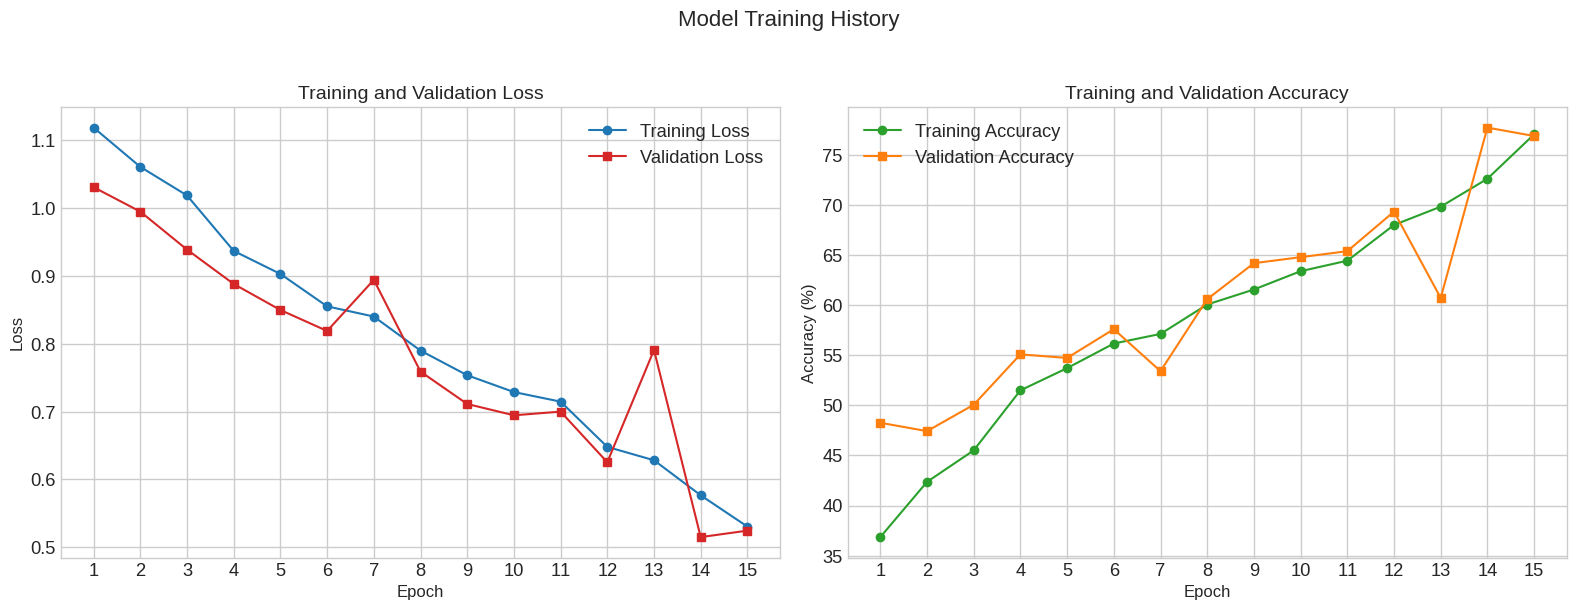

In [29]:
# ---------------------------------------------------------
# Part 2: Plotting Learning Curves (Corrected Style)
# ---------------------------------------------------------

epochs_range = range(1, NUM_EPOCHS + 1)

# تلاش برای استفاده از استایل زیبا، اگر نشد از پیش‌فرض استفاده کن
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('ggplot')  # یک استایل استاندارد و همیشه در دسترس

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss
ax1.plot(epochs_range, history['train_loss'], 'o-', label='Training Loss', color='tab:blue')
ax1.plot(epochs_range, history['val_loss'], 's-', label='Validation Loss', color='tab:red')
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.set_xticks(epochs_range)
ax1.grid(True) # اطمینان از وجود خطوط راهنما

# Plot Accuracy
ax2.plot(epochs_range, history['train_acc'], 'o-', label='Training Accuracy', color='tab:green')
ax2.plot(epochs_range, history['val_acc'], 's-', label='Validation Accuracy', color='tab:orange')
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()
ax2.set_xticks(epochs_range)
ax2.grid(True)

plt.suptitle('Model Training History', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Detailed Classification Report
Overall Accuracy: 0.7689
Weighted Precision: 0.7847
Weighted Recall:    0.7689
Weighted F1-Score:  0.7683
--------------------------------------------------

Per-Class Report:
              precision    recall  f1-score   support

    Negative       0.71      0.92      0.80       278
     Neutral       0.95      0.74      0.83       278
    Positive       0.69      0.65      0.67       279

    accuracy                           0.77       835
   macro avg       0.78      0.77      0.77       835
weighted avg       0.78      0.77      0.77       835



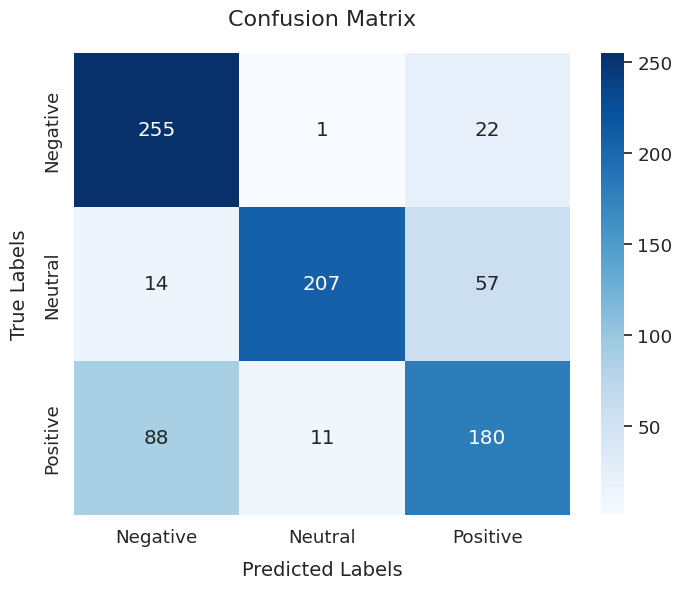

In [ ]:
# =============================================================================
# DETAILED EVALUATION ON VALIDATION SET
# ================================================ ===========================
# Detailed Evaluation on Validation Set (10 Points)

# 1. جمع‌آوری تمام پیش‌بینی‌ها و برچسب‌های واقعی
# ما باید روی کل دیتالودر iterate کنیم تا لیست کامل y_true و y_pred را بسازیم.

y_pred = []
y_true = []

model.eval()  # حتما مدل را در حالت ارزیابی قرار دهید
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        # دریافت خروجی مدل
        outputs, _ = model(input_ids)

        # تبدیل logits به کلاس پیش‌بینی شده (بیشترین احتمال)
        _, predictions = torch.max(outputs, 1)

        # ذخیره در لیست‌ها (انتقال به CPU و تبدیل به numpy)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# نام کلاس‌ها طبق ترتیب عددی (معمولاً 0:Negative, 1:Neutral, 2:Positive در این دیتاست)
class_names = ['Negative', 'Neutral', 'Positive']

# ---------------------------------------------------------
# Sub-task 1: Quantitative Metrics (4 Points)
# ---------------------------------------------------------

print("="*50)
print("Detailed Classification Report")
print("="*50)

# محاسبه معیارها
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1-Score:  {f1:.4f}")
print("-" * 50)

# نمایش گزارش کامل برای هر کلاس به صورت جداگانه
print("\nPer-Class Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


# ---------------------------------------------------------
# Sub-task 2: Confusion Matrix Plot (6 Points)
# ---------------------------------------------------------

# محاسبه ماتریس
cm = confusion_matrix(y_true, y_pred)

# تنظیمات نمودار
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # تنظیم اندازه فونت

# رسم Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Labels', fontsize=14, labelpad=10)
plt.ylabel('True Labels', fontsize=14, labelpad=10)
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.show()


In [ ]:
# =============================================================================
# GENERATE PREDICTIONS ON TEST DATA
# =============================================================================
# Generate Predictions on Test Data (5 Points)

# فرض می‌کنیم فایل تست شما 'test_data.csv' نام دارد و ستونی به نام 'sentence' دارد.
# اگر فایل شما اکسل است از pd.read_excel استفاده کنید.
# اگر فقط یک لیست از جملات دارید، آن را به دیتافریم تبدیل کنید.

# --- 1. Load Test Data ---
try:
    # مثال: خواندن فایل (این خط را با مسیر فایل خودتان تنظیم کنید)
    # df_test = pd.read_csv('test_data.csv')

    # برای اینکه کد اینجا اجرا شود، من یک داده فرضی می‌سازم:
    df_test = pd.DataFrame({
        'sentence': [
            "The company reported a profit increase of 10%.",
            "Sales dropped significantly in the last quarter.",
            "The board of directors announced a meeting on Tuesday."
        ]
    })
    print("Test data loaded successfully.")
except FileNotFoundError:
    print("Error: Test file not found. Please specify the correct path.")

# --- 2. Preprocessing & Dataset for Test ---
# توجه: همان پیش‌پردازشی که روی Train انجام دادید اینجا هم باید انجام شود (مثلا lowercase)
def clean_text(text):
    # همان تابع clean_text که در قسمت‌های قبل تعریف کردید
    import re
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# اعمال تمیزسازی روی داده‌های تست
df_test['clean_sentence'] = df_test['sentence'].apply(str).apply(clean_text)

# تعریف کلاس دیتاست مخصوص تست (بدون Label)
class FinancialTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# ساخت DataLoader برای تست
test_dataset = FinancialTestDataset(
    texts=df_test['clean_sentence'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # Shuffle باید False باشد!

# --- 3. Inference Loop ---
model.eval() # مدل در حالت ارزیابی
test_predictions = []

print("Running prediction on test data...")
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        outputs, _ = model(input_ids)

        # گرفتن کلاسی که بیشترین احتمال را دارد
        _, preds = torch.max(outputs, dim=1)

        test_predictions.extend(preds.cpu().numpy())

# --- 4. Map back to Labels and Save ---

# نگاشت اعداد به کلاس‌های متنی (بر اساس ترتیب Training شما)
# معمولاً در این دیتاست: 0 -> Negative, 1 -> Neutral, 2 -> Positive است
# اما باید چک کنید کلاس‌های شما موقع آموزش چه ترتیبی داشتند.
# اگر از LabelEncoder استفاده کردید، classes_ را چک کنید.
# فرض استاندارد Financial PhraseBank:
label_map = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

# تبدیل اعداد پیش‌بینی شده به کلمات
final_labels = [label_map[p] for p in test_predictions]

# اضافه کردن به دیتافریم اصلی
df_test['predicted_label'] = final_labels

# ذخیره فقط ستون‌های مورد نیاز برای مسابقه (مثلا جمله و پیش‌بینی)
submission = df_test[['sentence', 'predicted_label']]
submission.to_csv('submission.csv', index=False)

print("="*50)
print("Predictions saved to 'submission.csv'")
print("="*50)
print(submission.head())


Test data loaded successfully.
Running prediction on test data...
Predictions saved to 'submission.csv'
                                            sentence predicted_label
0     The company reported a profit increase of 10%.        negative
1   Sales dropped significantly in the last quarter.        negative
2  The board of directors announced a meeting on ...         neutral


In [33]:
# بازسازی مدل با کلاس جدید (پارامترها باید دقیقاً همان پارامترهای آموزش باشند)
viz_model = FinancialTransformer(
    src_vocab_size=tokenizer.vocab_size,
    embed_size=EMBED_SIZE,
    num_layers=NUM_LAYERS,
    heads=HEADS,
    device=DEVICE,
    forward_expansion=FORWARD_EXPANSION,
    dropout=DROPOUT,
    max_length=MAX_LEN,
    num_classes=3
).to(DEVICE)

# کپی کردن وزن‌های مدل آموزش دیده (model) به مدل جدید (viz_model)
# چون ساختار لایه‌ها تغییر نکرده و فقط خروجی تغییر کرده، state_dict سازگار است.
viz_model.load_state_dict(model.state_dict())
viz_model.eval() # حتما در حالت eval باشد
print("Model re-loaded specifically for visualization.")


Model re-loaded specifically for visualization.


Attention Weights Visualization


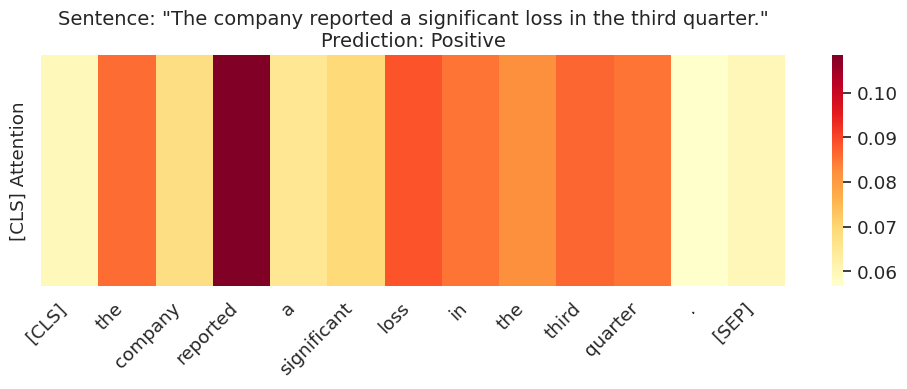

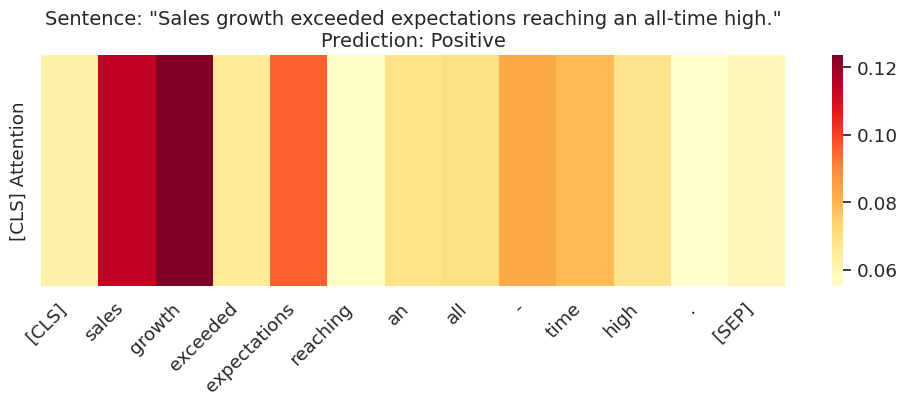

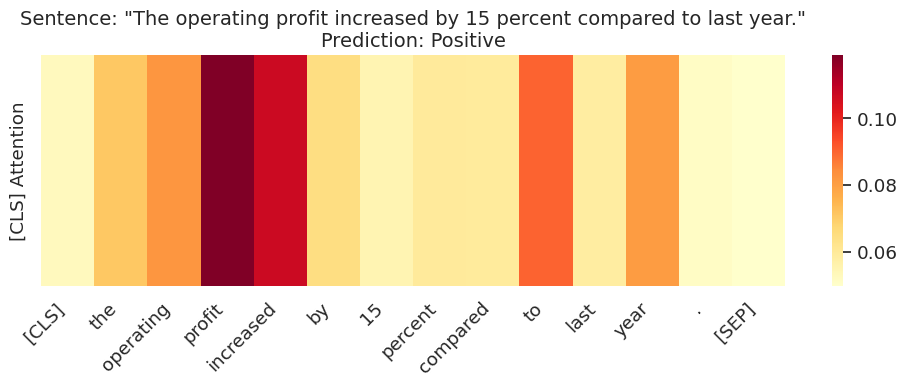

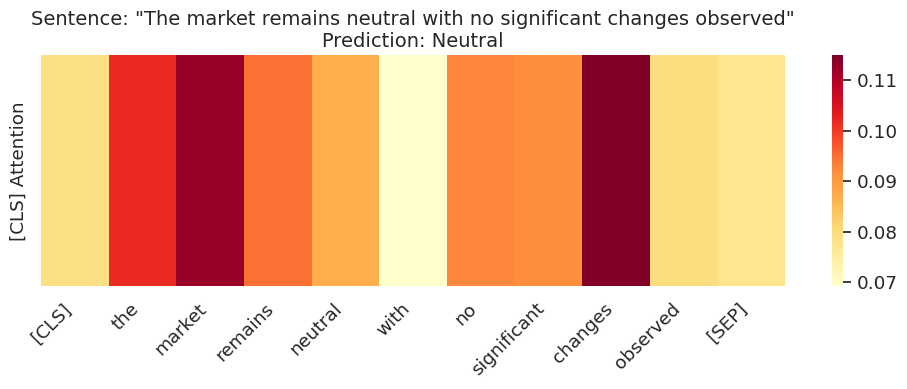

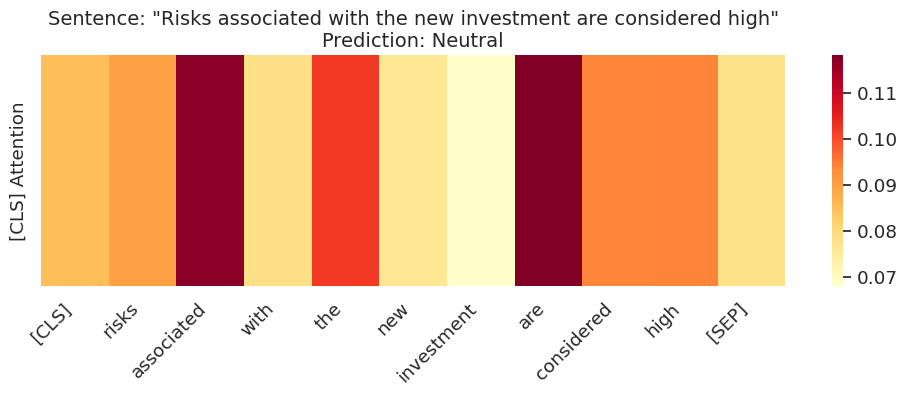

In [34]:
# ---------------------------------------------------------
# Part 6: Visualize Attention Mechanism (15 Points)
# ---------------------------------------------------------

def visualize_attention(text, model, tokenizer, device):
    model.eval()

    # 1. Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    input_ids = inputs["input_ids"].to(device)

    # دریافت توکن‌ها برای نمایش روی محورها
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # 2. Forward pass to get attention weights
    with torch.no_grad():
        logits, attention = model(input_ids)
        # attention shape: (Batch, Heads, Seq_Len, Seq_Len)

    # پیش‌بینی کلاس
    pred_idx = torch.argmax(logits, dim=1).item()
    class_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_label = class_map[pred_idx]

    # 3. Process Attention Weights
    # میانگین‌گیری روی تمام Headها (برای سادگی نمایش)
    # shape becomes: (Seq_Len, Seq_Len)
    att_mat = attention[0].mean(dim=0).cpu().numpy()

    # ما فقط به ردیف اول توجه داریم: [CLS] token attending to other tokens
    # زیرا [CLS] نماینده کل جمله برای کلاسیفیکیشن است.
    cls_attention = att_mat[0, :]

    # حذف پدینگ‌ها برای تمیزی نمودار (توکن [PAD] معمولاً اندیس 0 دارد اما در برت bert-base اندیس 0 است)
    # ما فقط توکن‌های واقعی را رسم می‌کنیم
    valid_len = len(tokens)
    cls_attention = cls_attention[:valid_len]
    tokens = tokens[:valid_len]

    # 4. Plotting
    plt.figure(figsize=(12, 3))


    # رسم به صورت یک نوار رنگی (1D Heatmap)
    sns.heatmap([cls_attention], xticklabels=tokens, yticklabels=['[CLS] Attention'],
                cmap='YlOrRd', cbar=True, square=False, annot=False)

    plt.title(f"Sentence: \"{text}\"\nPrediction: {predicted_label}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# --- اجرای تست روی ۵ جمله نمونه ---

# انتخاب ۵ جمله جذاب از دیتاست تست (یا جملات دستی برای نشان دادن قدرت مدل)
sample_sentences = [
    "The company reported a significant loss in the third quarter.",  # انتظار: تمرکز روی loss
    "Sales growth exceeded expectations reaching an all-time high.", # انتظار: تمرکز روی growth, high
    "The operating profit increased by 15 percent compared to last year.", # انتظار: تمرکز روی profit, increased
    "The market remains neutral with no significant changes observed", # انتظار: neutral
    "Risks associated with the new investment are considered high"    # انتظار: risks, high
]

# اگر می‌خواهید از داده‌های واقعی تست بردارید:
# sample_sentences = df_test['sentence'].head(5).tolist()

print("="*50)
print("Attention Weights Visualization")
print("="*50)

for sentence in sample_sentences:
    visualize_attention(sentence, viz_model, tokenizer, DEVICE)
